# Data Cleaning, EDA, and Modeling

## The Imports

In [1]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import k_means, DBSCAN
from sklearn.decomposition import PCA
import statsmodels.api as sm

%matplotlib inline

## Read In the Collected Data

### Read In the S&P 500 Financial Statement Data (This is a dictionary saved as a csv file)

In [2]:
spx_df = pd.read_csv('../data/spx_df.csv')

In [3]:
spx_df.head(2)

,Date,Ticker,Company,(BS) Cash And Cash Equivalents,(BS) Short Term Investments,(BS) Total Cash,(BS) Net Receivables,(BS) Inventory,(BS) Other Current Assets,(BS) Total Current Assets,...,(BS) Stockholders' Equity,(IS) Operating Expenses,(IS) Reported EPS,(IS) Weighted average shares outstanding,(IS) Basic 1,(IS) Diluted 1,(CF) Cash flows from operating activities,(CF) Cash flows from investing activities,(CF) Cash flows from financing activities,(CF) Free Cash Flow 1
0,2015-12-30,ADM,Archer-Daniels-Midland Company,910000.0,438000.0,1348000.0,2886000.0,8243000.0,687000.0,21829000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-12-30,ADM,Archer-Daniels-Midland Company,619000.0,296000.0,915000.0,2426000.0,8831000.0,451000.0,21045000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Read In the S&P 500 Company Sector Data as a pandas DataFrame

In [4]:
spx = pd.read_csv('../data/constituents_csv.csv')

In [5]:
spx.head()

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology


### Read In the S&P 500 Financial Stats as a pandas DataFrame

In [6]:
spx_stats = pd.read_csv('../data/spx_stats.csv')

In [7]:
spx_stats.shape

(474, 74)

## Data Cleaning

We have already done a lot of the cleaning during the scrape. Therefore, our cleaning work is easier here. 

### Cleaning the S&P 500 Stats DataFrame

First, let's start simple and start cleaning spx_stats since it is already a standarized format. We will drop some unneccessary columns and drop the columns with more than 50 missing values.

In [8]:
# Drop the Unammed: 0 column.
spx_stats.drop(columns='Unnamed: 0', inplace=True)

In [9]:
# Drop the symbol column, it is redundent.
spx_stats.drop(columns='Symbol', inplace=True)

In [10]:
spx_stats = spx_stats.loc[:, spx_stats.isnull().sum() < 50]

## Cleaning the Financial Statements

The cleaning here is a bit more complex. As the accounting system allows certain flexibility, companies report slightly different line items in their financial statements. It would be a mess to directly concat the DataFrames. 

Instead, we try to take a look under the hood and only grab the key columns we need for our purpose. We need to make sure the columns that we need for modeling are common among the companies. To do this, we created another function to quickly test if a particular column is widely reported by companies tracked in S&P 500.

### Find a List of Useful Columns to Include for Our Purpose

In [11]:
bs_cols = [col for col in spx_df.columns if col.startswith('(BS)')]
bs_cols.insert(0, 'Ticker')
is_cols = [col for col in spx_df.columns if col.startswith('(IS)')]
is_cols.insert(0, 'Ticker')
cf_cols = [col for col in spx_df.columns if col.startswith('(CF)')]
cf_cols.insert(0, 'Ticker')

In [12]:
useful_list = ['Date',
               'Ticker',
               '(BS) Cash And Cash Equivalents', 
               '(BS) Short Term Investments',
               '(BS) Total Cash',
               '(BS) Gross property, plant and equipment',
               '(BS) Accumulated Depreciation',
               '(BS) Net property, plant and equipment',
               '(BS) Total Assets',
               '(BS) Accounts Payable',
               '(BS) Taxes payable',
               '(BS) Accrued liabilities',
               '(BS) Deferred revenues',
               '(BS) Other Current Liabilities',
               '(BS) Total Liabilities',
               '(BS) Retained Earnings',
               '(BS) Total liabilities and stockholders\' equity',
               '(IS) Total Revenue',
               '(IS) Cost of Revenue',
               '(IS) Gross Profit',
               '(IS) Total Operating Expenses',
               '(IS) Operating Income or Loss',
               '(IS) Interest Expense',
               '(IS) Income Before Tax',
               '(IS) Income Tax Expense',
               '(IS) Net Income',
               '(IS) Net Income available to common shareholders',
               '(IS) EBITDA',
               '(CF) Depreciation & amortization',
               '(CF) Change in working capital',
               '(CF) Capital Expenditure',
               '(CF) Free Cash Flow',
               '(CF) Dividends Paid',
               '(CF) Net cash provided by operating activites',
               '(CF) Net cash used privided by (used for) financing activities',
               '(CF) Net cash used for investing activites']

In [13]:
spx_fin = spx_df[useful_list]

### Clean the `spx_fin` DataFrame: Make Sure We Have the Target Variable for All Observations

In [14]:
# Drop duplicates
spx_fin.drop_duplicates(inplace=True)

/Users/guoningli/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Total cash can be inferred from Cash and Cash Equivalents. Therefore, we want to make sure we have a total cash available for each observation. There are many reasons why total cash or categorized cash numbers are missing. This could due to a young company who went IPO and filed for a incomplete statement during their first year. This is totally normal. For our purposes, we will drop such rows.

In [15]:
# Take a look at the missing values.
spx_fin.loc[spx_fin['(BS) Cash And Cash Equivalents'].isnull().astype(int) == 1]

,Date,Ticker,(BS) Cash And Cash Equivalents,(BS) Short Term Investments,(BS) Total Cash,"(BS) Gross property, plant and equipment",(BS) Accumulated Depreciation,"(BS) Net property, plant and equipment",(BS) Total Assets,(BS) Accounts Payable,...,(IS) Net Income available to common shareholders,(IS) EBITDA,(CF) Depreciation & amortization,(CF) Change in working capital,(CF) Capital Expenditure,(CF) Free Cash Flow,(CF) Dividends Paid,(CF) Net cash provided by operating activites,(CF) Net cash used privided by (used for) financing activities,(CF) Net cash used for investing activites
393,2016-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1072000.0,2031000.0,170000.0,-536000.0,-107000.0,990000.0,-36000.0,1097000.0,-913000.0,-168000.0
598,2019-08-30,MU,NaN,NaN,7955000.0,NaN,NaN,28240000.0,48887000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
901,2019-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1034000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2018-12-30,CAT,NaN,NaN,7857000.0,29781000.0,-16207000.0,13574000.0,78509000.0,7051000.0,...,6147000.0,10992000.0,2766000.0,-4077000.0,-2916000.0,3642000.0,-1951000.0,6558000.0,-3650000.0,-3212000.0
1050,2015-12-30,FTV,NaN,NaN,NaN,1491600.0,-976800.0,514800.0,7210600.0,657100.0,...,805700.0,1446600.0,176900.0,-78900.0,-120100.0,888900.0,NaN,1009000.0,-834900.0,-174100.0
1676,2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,2910000.0,530000.0,-606000.0,-607000.0,670000.0,NaN,1277000.0,-515000.0,-466000.0


In [16]:
# We can see that there are some tickers missing. Drop these rows as this could very likely be a scraping error.
spx_fin = spx_fin.loc[spx_fin['Ticker'].notnull()]

In [17]:
# Finally, FTV's 2015 filing is incomplete as they went public that year. Drop this row.
spx_fin = spx_fin.drop(1050, axis=0)

In [18]:
# MU and CAT reported Total Cash, which is eventually what we want. So this is OK.
spx_fin.loc[spx_fin['(BS) Cash And Cash Equivalents'].isnull()]

,Date,Ticker,(BS) Cash And Cash Equivalents,(BS) Short Term Investments,(BS) Total Cash,"(BS) Gross property, plant and equipment",(BS) Accumulated Depreciation,"(BS) Net property, plant and equipment",(BS) Total Assets,(BS) Accounts Payable,...,(IS) Net Income available to common shareholders,(IS) EBITDA,(CF) Depreciation & amortization,(CF) Change in working capital,(CF) Capital Expenditure,(CF) Free Cash Flow,(CF) Dividends Paid,(CF) Net cash provided by operating activites,(CF) Net cash used privided by (used for) financing activities,(CF) Net cash used for investing activites
598,2019-08-30,MU,NaN,NaN,7955000.0,NaN,NaN,28240000.0,48887000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,2018-12-30,CAT,NaN,NaN,7857000.0,29781000.0,-16207000.0,13574000.0,78509000.0,7051000.0,...,6147000.0,10992000.0,2766000.0,-4077000.0,-2916000.0,3642000.0,-1951000.0,6558000.0,-3650000.0,-3212000.0


The next step is to make sure there's no null values in our target variable: (BS) Total Cash. We know that total cash:

- Total Cash = Cash & Cash Equivalent + Short-term Investments
<br>

First, fill the nas for short-term investments

In [19]:
spx_fin['(BS) Short Term Investments'].fillna(0, inplace=True)

In [20]:
spx_fin['(BS) Total Cash'].fillna(spx_fin['(BS) Cash And Cash Equivalents'] + spx_fin['(BS) Short Term Investments'],
                                  inplace=True)

In [21]:
spx_fin.loc[spx_fin['(BS) Total Cash'].isnull()]

,Date,Ticker,(BS) Cash And Cash Equivalents,(BS) Short Term Investments,(BS) Total Cash,"(BS) Gross property, plant and equipment",(BS) Accumulated Depreciation,"(BS) Net property, plant and equipment",(BS) Total Assets,(BS) Accounts Payable,...,(IS) Net Income available to common shareholders,(IS) EBITDA,(CF) Depreciation & amortization,(CF) Change in working capital,(CF) Capital Expenditure,(CF) Free Cash Flow,(CF) Dividends Paid,(CF) Net cash provided by operating activites,(CF) Net cash used privided by (used for) financing activities,(CF) Net cash used for investing activites


In [22]:
# Drop the cash and cash equivalent and short-term investment columns for simplicity purposes.
spx_fin.drop(columns=['(BS) Cash And Cash Equivalents', '(BS) Short Term Investments'], inplace=True)

### Clean the `spx_fin` DataFrame: Dealing w/ Other Nulls

In [23]:
# For PPE items, we can simply fillna with 0. Some companies don't have PPE.
spx_fin['(BS) Gross property, plant and equipment'] = spx_fin['(BS) Gross property, plant and equipment'].fillna(0)
spx_fin['(BS) Accumulated Depreciation'] = spx_fin['(BS) Accumulated Depreciation'].fillna(0)

# We can drop Net PPE since we have the other two broken down conponents.
spx_fin.drop(columns='(BS) Net property, plant and equipment', inplace=True)

In [24]:
# For short-term liability items, since some companies don't have these liabilities, it is also safe to fillna with 0.
spx_fin['(BS) Accounts Payable'] = spx_fin['(BS) Accounts Payable'].fillna(0)
spx_fin['(BS) Taxes payable'] = spx_fin['(BS) Taxes payable'].fillna(0)
spx_fin['(BS) Accrued liabilities'] = spx_fin['(BS) Accrued liabilities'].fillna(0)
spx_fin['(BS) Deferred revenues'] = spx_fin['(BS) Deferred revenues'].fillna(0)
spx_fin['(BS) Other Current Liabilities'] = spx_fin['(BS) Other Current Liabilities'].fillna(0)

In [25]:
# Let's take a look at retained earnings, and why some of the values are missing.
# For the missing values, we can infer from total shareholder's equity.
# The average retained earning over shareholder's equity over the S&P 500 companies is around 26%.
mean_re_perc = np.mean(spx_fin['(BS) Retained Earnings'] / spx_fin['(BS) Total liabilities and stockholders\' equity'])
spx_fin['(BS) Retained Earnings'] = spx_fin['(BS) Retained Earnings'].fillna(spx_fin['(BS) Total liabilities and stockholders\' equity']*mean_re_perc)

Revenue is a key part of our project and we are seeing 12 rows with hidden value. After some digging on Yahoo Finance, we found that the following data is incomplete and hidden from the page. We should have other ways to collect these data, using the official 10K or 10Q. But given the time contrainst, we will for now drop these rows.

In [26]:
spx_fin[spx_fin['(IS) Total Revenue'].isnull()]

,Date,Ticker,(BS) Total Cash,"(BS) Gross property, plant and equipment",(BS) Accumulated Depreciation,(BS) Total Assets,(BS) Accounts Payable,(BS) Taxes payable,(BS) Accrued liabilities,(BS) Deferred revenues,...,(IS) Net Income available to common shareholders,(IS) EBITDA,(CF) Depreciation & amortization,(CF) Change in working capital,(CF) Capital Expenditure,(CF) Free Cash Flow,(CF) Dividends Paid,(CF) Net cash provided by operating activites,(CF) Net cash used privided by (used for) financing activities,(CF) Net cash used for investing activites
142,2019-08-30,AZO,176300.0,0.0,0.0,9895913.0,4864912.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,2019-09-29,DHI,1494300.0,462200.0,0.0,15606600.0,634000.0,0.0,1278100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,2019-09-29,FFIV,972282.0,0.0,0.0,3390275.0,62627.0,0.0,235869.0,807030.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
558,2019-10-30,HPE,3753000.0,0.0,0.0,51803000.0,5595000.0,186000.0,4197000.0,3234000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562,2019-10-30,HPQ,4537000.0,0.0,0.0,33467000.0,14793000.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
598,2019-08-30,MU,7955000.0,0.0,0.0,48887000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,2019-10-30,DE,3857000.0,13540000.0,0.0,73011000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1096,2019-09-29,JEC,631068.0,804931.0,-496788.0,11462711.0,1072645.0,0.0,1384379.0,414208.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1156,2019-09-29,ROK,1058000.0,2137900.0,-1566000.0,6113000.0,694600.0,62900.0,15500.0,275600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1369,2015-12-30,PRGO,417800.0,1659000.0,-772800.0,19393900.0,554900.0,0.0,831700.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
spx_fin = spx_fin[spx_fin['(IS) Total Revenue'].notnull()]

There will be some significant inferrance going on in the next section. In order to get the real values as accurate as possible, we need to fill the sector data for each company as companies in a specific sector behave in a similar fashion.

But again, with time constratins. We will use this method in future editions and trust the law of large numbers. Instead of going sector by sector, we are just going to use the average of the S&P 500 companies to deduce these missing values.

In [28]:
spx_fin = spx_fin.merge(spx, how='left', left_on='Ticker', right_on='Symbol').drop(columns='Symbol')

In [29]:
# Fillna for cost of revenue by the mean.
mean_gr_perc = np.mean(spx_fin['(IS) Cost of Revenue'] / spx_fin['(IS) Total Revenue'])
spx_fin['(IS) Cost of Revenue'] = spx_fin['(IS) Cost of Revenue'].fillna(spx_fin['(IS) Total Revenue']*mean_gr_perc)

In [30]:
# After we are done with the cost of revenue, we can fill the gross revenue as it is a simple deduction.
spx_fin['(IS) Gross Profit'] = spx_fin['(IS) Gross Profit'].fillna(spx_fin['(IS) Total Revenue']-spx_fin['(IS) Cost of Revenue'])

In [31]:
# Same way as above, we fillnas for the operating expenses and operating profits.
mean_oex_perc = np.mean(spx_fin['(IS) Total Operating Expenses'] / spx_fin['(IS) Total Revenue'])
spx_fin['(IS) Total Operating Expenses'] = spx_fin['(IS) Total Operating Expenses'].fillna(spx_fin['(IS) Total Revenue']*mean_oex_perc)

In [32]:
# Fill the operating income or loss based on this.
spx_fin['(IS) Operating Income or Loss'] = spx_fin['(IS) Operating Income or Loss'].fillna(spx_fin['(IS) Gross Profit']-spx_fin['(IS) Total Operating Expenses'])

In [33]:
# For interest expense and income tax expenses, it's reasonable that a few companies don't have debt or experiencing loss.
spx_fin['(IS) Interest Expense'] = spx_fin['(IS) Interest Expense'].fillna(0)
spx_fin['(IS) Income Tax Expense'] = spx_fin['(IS) Income Tax Expense'].fillna(0)

In [34]:
# We will return to EBITA last, let's first deal with cash flows.
# There are 2 rows without any cash flows, smoke them out and drop.
spx_fin = spx_fin[spx_fin['(CF) Net cash provided by operating activites'].notnull()]

In [35]:
# Some companies don't pay dividends. Fill with 0s.
spx_fin['(CF) Dividends Paid'] = spx_fin['(CF) Dividends Paid'].fillna(0)

In [36]:
# Depreciation and amortization can be thought as a function of operating cash flow.
# Again, there are better ways to do this based on sectors. But for now, I'll settle with the mean of the mass.
mean_da_perc = np.mean(spx_fin['(CF) Depreciation & amortization'] / spx_fin['(CF) Net cash provided by operating activites']) 
spx_fin['(CF) Depreciation & amortization'] = spx_fin['(CF) Depreciation & amortization'].fillna(spx_fin['(CF) Net cash provided by operating activites']*mean_da_perc)

In [37]:
# Same way with change in working capital. Follow the approach of the above cell.
mean_wc_perc = np.mean(spx_fin['(CF) Change in working capital'] / spx_fin['(CF) Net cash provided by operating activites']) 
spx_fin['(CF) Change in working capital'] = spx_fin['(CF) Change in working capital'].fillna(spx_fin['(CF) Net cash provided by operating activites']*mean_wc_perc)

In [38]:
# Missing capex will be deduced bassed on the Revenue.
mean_wc_perc = np.mean(spx_fin['(CF) Capital Expenditure'] / spx_fin['(IS) Total Revenue']) 
spx_fin['(CF) Capital Expenditure'] = spx_fin['(CF) Capital Expenditure'].fillna(spx_fin['(IS) Total Revenue']*mean_wc_perc)

In [39]:
# Now, let's deal with EBITDA.
spx_fin['(IS) EBITDA'] = spx_fin['(IS) EBITDA'].fillna(spx_fin['(IS) Net Income']+spx_fin['(IS) Interest Expense']+spx_fin['(IS) Income Tax Expense']+spx_fin['(CF) Depreciation & amortization'])

In [40]:
# Finally, free cash flow.
spx_fin['(CF) Free Cash Flow'] = spx_fin['(CF) Free Cash Flow'].fillna(spx_fin['(IS) Net Income']+spx_fin['(IS) Interest Expense']-spx_fin['(IS) Interest Expense']*0.21+spx_fin['(CF) Change in working capital']-spx_fin['(CF) Capital Expenditure'])

In [41]:
# We are all good to go.
spx_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 0 to 1870
Data columns (total 35 columns):
Date                                                              1869 non-null object
Ticker                                                            1869 non-null object
(BS) Total Cash                                                   1869 non-null float64
(BS) Gross property, plant and equipment                          1869 non-null float64
(BS) Accumulated Depreciation                                     1869 non-null float64
(BS) Total Assets                                                 1869 non-null float64
(BS) Accounts Payable                                             1869 non-null float64
(BS) Taxes payable                                                1869 non-null float64
(BS) Accrued liabilities                                          1869 non-null float64
(BS) Deferred revenues                                            1869 non-null float64
(BS) Other Curr

In [42]:
spx_fin.set_index('Date', inplace=True)

## EDA: Financial Statement

### Correlation Between Cash Balance and Rest of the Data

Text(0.5, 1.0, 'Correlation Between Cash Balance and Other Items on the Financial Statement')

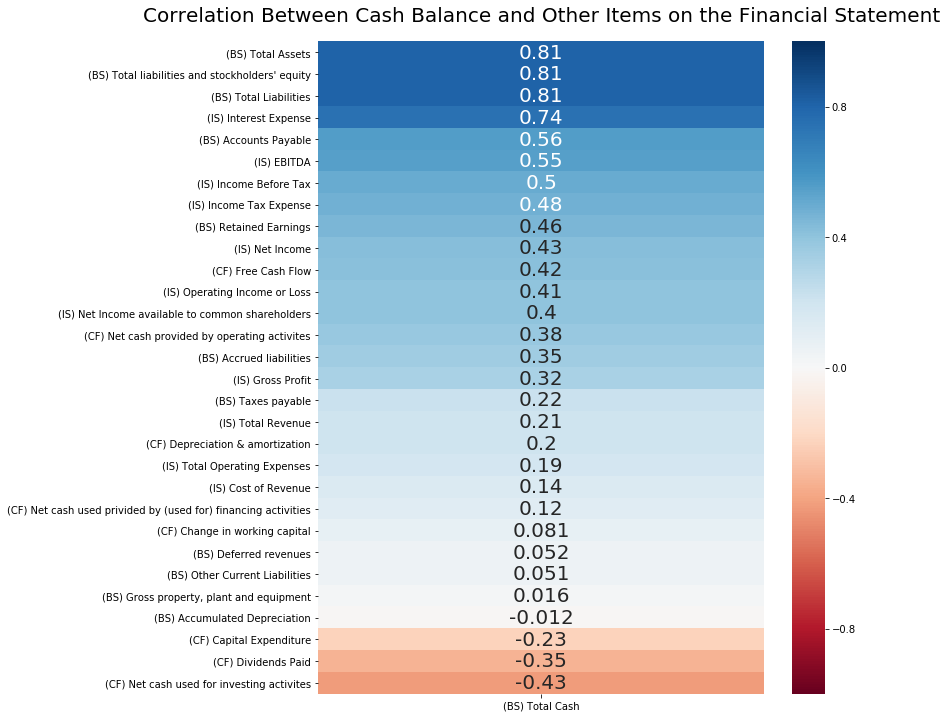

In [43]:
plt.figure(figsize=(10,12))
sns.heatmap(spx_fin.corr()[['(BS) Total Cash']][1:].sort_values('(BS) Total Cash', ascending=False),
            annot=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1,
            annot_kws={'size' : 20})
plt.title('Correlation Between Cash Balance and Other Items on the Financial Statement',
          fontsize=20,
          pad=20)

### Mean Cash Balance by Industry

<Figure size 720x576 with 0 Axes>

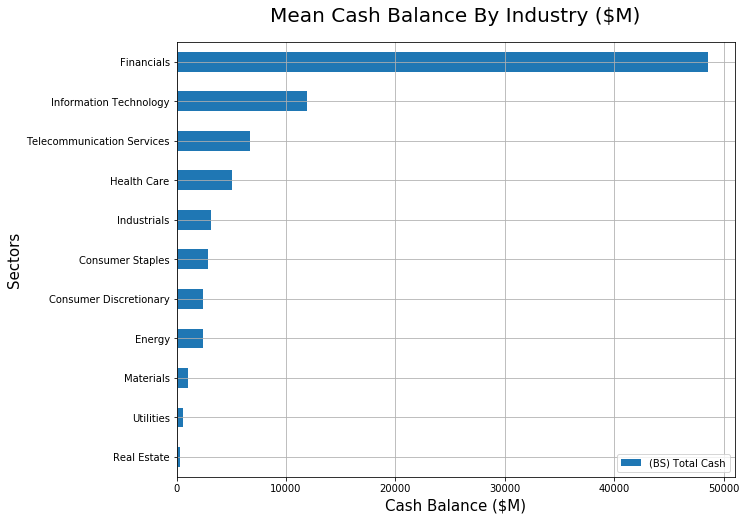

In [80]:
plt.figure(figsize=(10,8))
(spx_fin.groupby('Sector').mean().sort_values('(BS) Total Cash')[['(BS) Total Cash']]/1000).plot.barh(figsize=(10,8))
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Cash Balance ($M)', fontsize=15)
plt.ylabel('Sectors', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Mean Cash Balance By Industry ($M)', fontsize=20, pad=20);

### Cash/Asset Ration By Industry (Adjusted to Scale)

In [45]:
# Add a new column to adjust for scale of a company
spx_fin['Cash/Total Asset'] = spx_fin['(BS) Total Cash'] / spx_fin['(BS) Total Assets']

<Figure size 720x576 with 0 Axes>

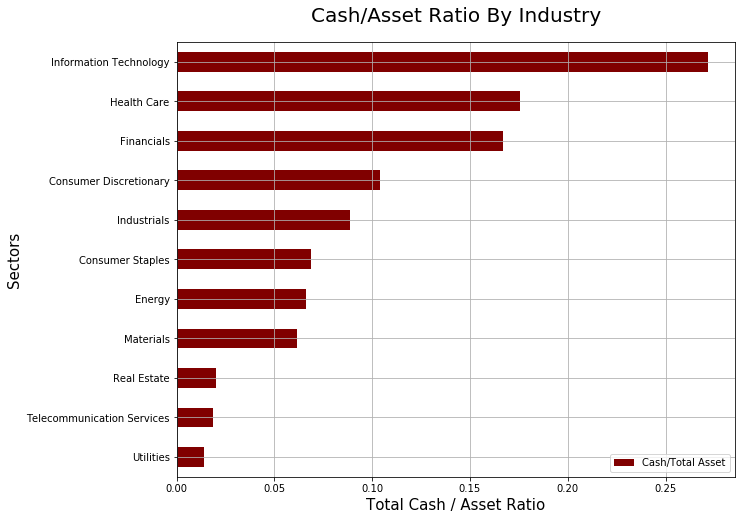

In [79]:
plt.figure(figsize=(10,8))
(spx_fin.groupby('Sector').mean().sort_values('Cash/Total Asset')[['Cash/Total Asset']]).plot.barh(figsize=(10,8), color='maroon')
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Total Cash / Asset Ratio', fontsize=15)
plt.ylabel('Sectors', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Cash/Asset Ratio By Industry', fontsize=20, pad=20);

### Get Most Recent Financial Statements

We have multiple years of financial statements in our hand. But we are more interested in the most recent year with the exception of growth rate. 

**NOTE:** With time contrainst, we haven't been able to calculate growth rate but used some proxy provided by the statistics of Yahoo Finance.

In [47]:
# Find the most recent statement for each company.
spx_fin_recent = spx_fin.sort_index(axis=0, ascending=True).drop_duplicates(['Ticker'], keep='last')

In [48]:
spx_fin_recent['(BS) Total Cash'].sort_values()

Date
2018-12-30            0.0
2018-12-30          545.0
2018-12-30         2287.0
2018-12-30         3487.0
2018-12-30         4000.0
                 ...     
2018-12-30    173809000.0
2018-12-30    184898000.0
2018-12-30    278793000.0
2018-12-30    443199000.0
2018-12-30    476143000.0
Name: (BS) Total Cash, Length: 474, dtype: float64

### Take a Look at Our y Variable, Much Better with Log

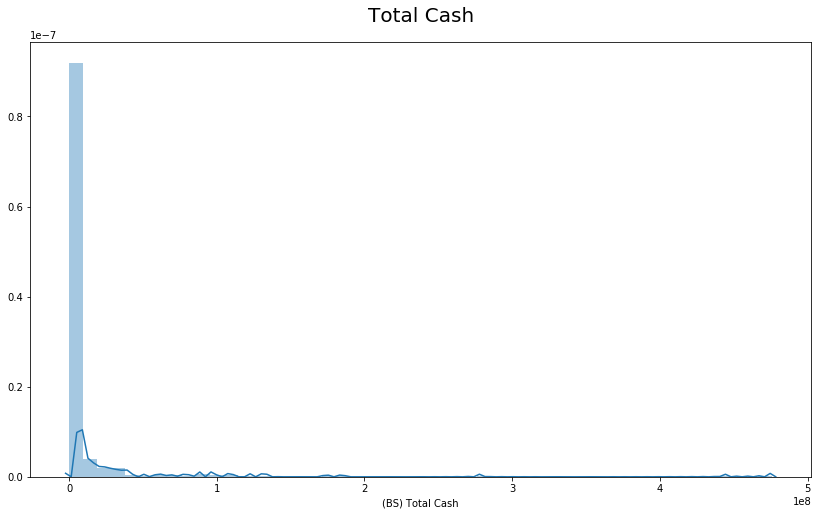

In [84]:
plt.figure(figsize=(14,8))
sns.distplot(spx_fin_recent['(BS) Total Cash'])
plt.title('Total Cash', fontsize=20, pad=20);

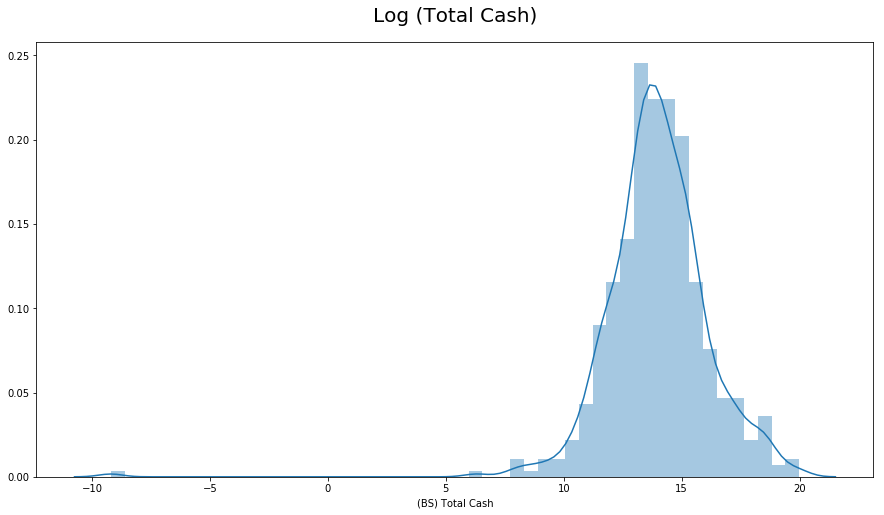

In [82]:
plt.figure(figsize=(15,8))
sns.distplot(np.log(spx_fin_recent['(BS) Total Cash']+0.0001))
plt.title('Log (Total Cash)', fontsize=20, pad=20);

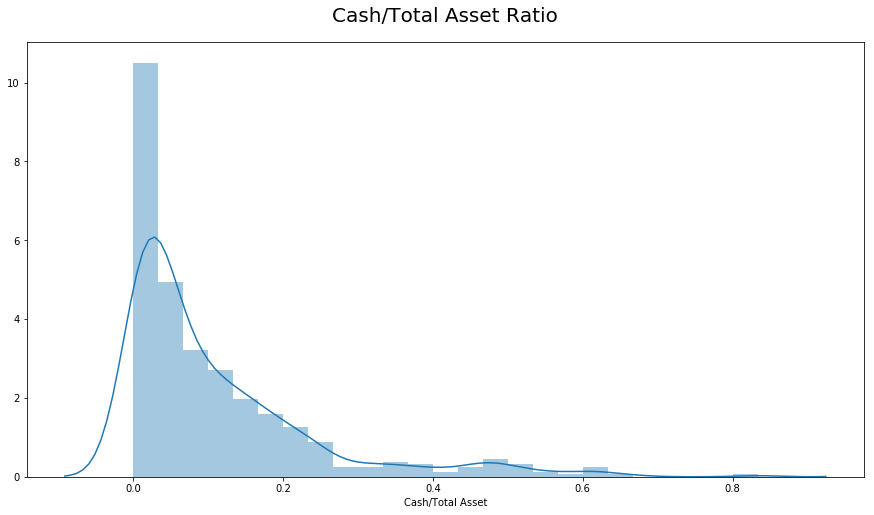

In [83]:
plt.figure(figsize=(15,8))
sns.distplot(spx_fin_recent['Cash/Total Asset'])
plt.title('Cash/Total Asset Ratio', fontsize=20, pad=20);

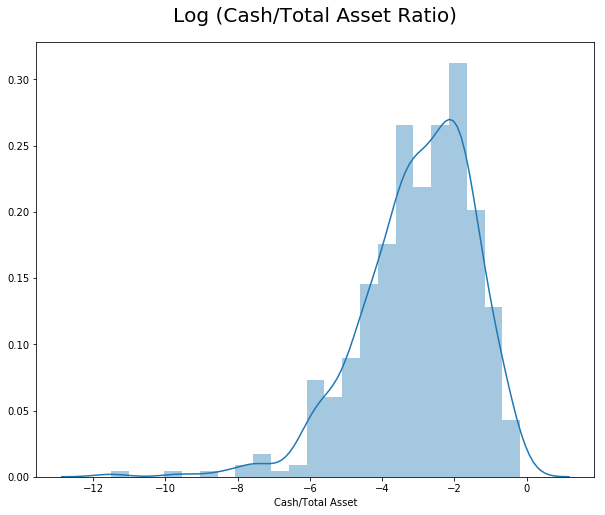

In [52]:
plt.figure(figsize=(10,8))
sns.distplot(np.log(spx_fin_recent['Cash/Total Asset']+0.00001))
plt.title('Log (Cash/Total Asset Ratio)', fontsize=20, pad=20);

## Modeling

### Establish a Baseline

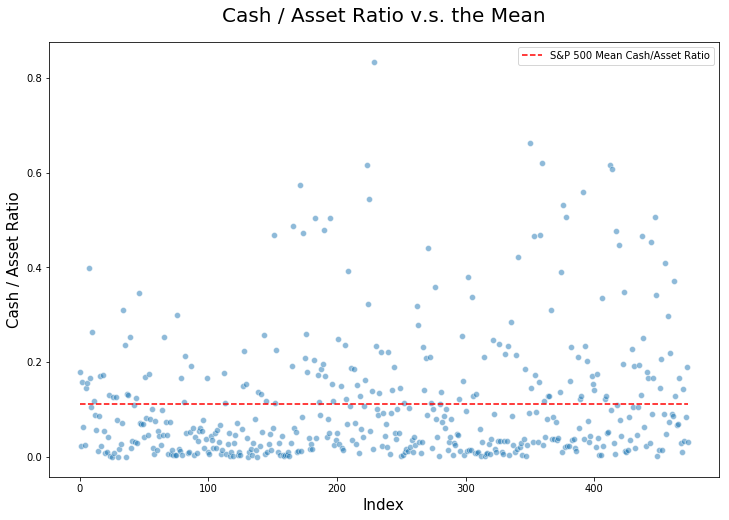

In [53]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(len(spx_fin_recent['Cash/Total Asset'])),
                y=spx_fin_recent['Cash/Total Asset'],
                alpha=0.5)
plt.hlines(y=np.mean(spx_fin_recent['Cash/Total Asset']),
           xmin=0,
           xmax=473,
           color='r',
           linestyles='dashed',
           label='S&P 500 Mean Cash/Asset Ratio')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Index', fontsize=15)
plt.ylabel('Cash / Asset Ratio', fontsize=15)
plt.legend()
plt.title('Cash / Asset Ratio v.s. the Mean',
          fontsize=20,
          pad=20);

### Create Feature and Target

In [54]:
stats_useful_list = ['Ticker',
                     'Name',
                     'Sector',
                     '% Held by Insiders',
                     '% Held by Institutions',
                     'Beta (3Y Monthly)',
                     'Current Ratio (mrq)',
                     'Diluted EPS (ttm)',
                     'EBITDA',
                     'Enterprise Value',
                     'Enterprise Value/EBITDA',
                     'Enterprise Value/Revenue',
                     'Forward P/E',
                     'Gross Profit (ttm)',
                     'Market Cap (intraday)',
                     'PEG Ratio (5 yr expected)',
                     'Payout Ratio',
                     'Price/Book (mrq)',
                     'Price/Sales (ttm)',
                     'Quarterly Revenue Growth (yoy)',
                     'Return on Assets (ttm)',
                     'Return on Equity (ttm)',
                     'S&P500 52-Week Change',
                     'Short Ratio (Nov 15, 2019)',
                     'Total Cash (mrq)',
                     'Total Debt (mrq)',
                     'Total Debt/Equity (mrq)',
                     'Trailing P/E']

In [55]:
spx_stats_useful = spx_stats[stats_useful_list]
df_final = spx_stats_useful.merge(spx_fin_recent.drop(columns=['Name','Sector']), how='left', on='Ticker')
df_final = pd.get_dummies(df_final, columns=['Sector'], drop_first=True)

In [56]:
df_final

,Ticker,Name,% Held by Insiders,% Held by Institutions,Beta (3Y Monthly),Current Ratio (mrq),Diluted EPS (ttm),EBITDA,Enterprise Value,Enterprise Value/EBITDA,...,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities
0,ADM,Archer-Daniels-Midland Co,0.0032,0.8037,1.10,1.60,2.10,2.520000e+09,3.278000e+10,13.01,...,1,0,0,0,0,0,0,0,0,0
1,CPB,Campbell Soup,0.4438,0.5386,0.41,0.58,0.70,1.480000e+09,2.248000e+10,15.19,...,1,0,0,0,0,0,0,0,0,0
2,CHD,Church & Dwight,0.0023,0.8844,0.11,0.80,2.44,1.000000e+09,1.947000e+10,19.46,...,1,0,0,0,0,0,0,0,0,0
3,KO,Coca-Cola Company (The),0.0075,0.6899,0.45,0.92,1.81,1.067000e+10,2.615800e+11,24.51,...,1,0,0,0,0,0,0,0,0,0
4,CL,Colgate-Palmolive,0.0037,0.7851,0.72,1.03,2.70,4.040000e+09,6.656000e+10,16.49,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,VMC,Vulcan Materials,0.0023,0.9878,0.90,2.47,4.50,1.230000e+09,2.189000e+10,17.77,...,0,0,0,0,0,0,1,0,0,0
470,WRK,WestRock Company,0.0136,0.9014,1.66,1.45,3.33,2.970000e+09,2.033000e+10,6.85,...,0,0,0,0,0,0,1,0,0,0
471,T,AT&T Inc,0.0007,0.5544,0.61,0.74,2.23,5.403000e+10,4.751400e+11,8.79,...,0,0,0,0,0,0,0,0,1,0
472,CTL,CenturyLink Inc,0.0078,0.7520,0.89,0.70,-7.39,9.180000e+09,5.129000e+10,5.59,...,0,0,0,0,0,0,0,0,1,0


In [57]:
X_cols = ['Beta (3Y Monthly)',
 'Current Ratio (mrq)',
 'PEG Ratio (5 yr expected)',
 'Payout Ratio',
 'Quarterly Revenue Growth (yoy)',
 'Return on Assets (ttm)',
 'Return on Equity (ttm)',
 'Total Debt (mrq)',
 'Total Debt/Equity (mrq)',
 '(BS) Gross property, plant and equipment',
 '(BS) Accumulated Depreciation',
 '(BS) Total Assets',
 '(BS) Accounts Payable',
 '(BS) Taxes payable',
 '(BS) Accrued liabilities',
 '(BS) Deferred revenues',
 '(BS) Other Current Liabilities',
 '(BS) Total Liabilities',
 '(BS) Retained Earnings',
 "(BS) Total liabilities and stockholders' equity",
 '(IS) Total Revenue',
 '(IS) Cost of Revenue',
 '(IS) Gross Profit',
 '(IS) Total Operating Expenses',
 '(IS) Operating Income or Loss',
 '(IS) Interest Expense',
 '(IS) Income Before Tax',
 '(IS) Income Tax Expense',
 '(IS) Net Income',
 '(IS) Net Income available to common shareholders',
 '(IS) EBITDA',
 '(CF) Depreciation & amortization',
 '(CF) Change in working capital',
 '(CF) Capital Expenditure',
 '(CF) Free Cash Flow',
 '(CF) Dividends Paid',
 '(CF) Net cash provided by operating activites',
 '(CF) Net cash used privided by (used for) financing activities',
 '(CF) Net cash used for investing activites',
 'Sector_Consumer Staples',
 'Sector_Energy',
 'Sector_Financials',
 'Sector_Health Care',
 'Sector_Industrials',
 'Sector_Information Technology',
 'Sector_Materials',
 'Sector_Real Estate',
 'Sector_Telecommunication Services',
 'Sector_Utilities']

In [58]:
y = np.log(df_final['(BS) Total Cash']+0.000001)
X = df_final[X_cols].fillna(0)

### Linear Regression

We are building a linear regression to project the "fair cash balance" of a company with specific characteristics: growth, scale, retention rate, etc. 

There are many ways we could improve this model, including but not limited to the following:

- Get more historical data to better understand the company's grwoth tractory instead of just relying on current day statistics.
- Deep dive into sectors and industries within those sectors to understand how companies with different characteristcs behave.
- Understanding macro market environment, such as interest rate, inflation, unemployment and overall GDP growth.
- Puting these company on a global scale, looking not only how companies perform in the US but how they behave in Europe, Asia Pacifics, South America and other global and regional markets.
- Infer better data points that are more correlated with our target, such as weight average cost of capital, return on capital, research and operations, etc.

Right now, we have a MVP, which is a fundamental project we can built upon. From this project, we are just scratching the surface of the topic but we have the tools to make drive much more insight.

In [59]:
lr = LinearRegression()
lr.fit(X,y)
lr.score(X,y)

0.4642600100768648

In [60]:
y_fair = lr.predict(X)

In [61]:
X = sm.add_constant(X)
lm = sm.OLS(y,X).fit()
lm.summary()

/Users/guoningli/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        (BS) Total Cash   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     7.673
Date:                Wed, 04 Dec 2019   Prob (F-statistic):           2.86e-34
Time:                        17:41:56   Log-Likelihood:                -927.87
No. Observations:                 474   AIC:                             1954.
Df Residuals:                     425   BIC:                             2158.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             12.5764      0.389     32.371      0.000      11.813      13.340
Beta (3Y Monthly)                                                  0.6433      0.228      2.818      0.005       0.195       1.092
Current Ratio (mrq)                                                0.0310      0.063      0.494      0.622      -0.092       0.154
PEG Ratio (5 yr expected)                                         -0.0012      0.002     -0.636      0.525      -0.005       0.003
Payout Ratio                                                       0.0142      0.035      0.410      0.682      -0.054       0.082
Quarterly Revenue Growth (yoy)                                     0.5690      0.568      1.003      0.317      -0.547       1.685
Return on Assets (ttm)                                            -1.1845      2.503     -0.473      0.636      -6.104       3.735
Return on Equity (ttm)                                            -0.0089      0.018     -0.484      0.629      -0.045       0.027
Total Debt (mrq)                                               -7.864e-12   1.12e-11     -0.705      0.481   -2.98e-11    1.41e-11
Total Debt/Equity (mrq)                                         4.729e-05   6.83e-05      0.692      0.489    -8.7e-05       0.000
(BS) Gross property, plant and equipment                        8.796e-10   1.48e-08      0.059      0.953   -2.83e-08       3e-08
(BS) Accumulated Depreciation                                   1.043e-08   2.51e-08      0.416      0.677   -3.88e-08    5.97e-08
(BS) Total Assets                                              -8.419e-08   8.23e-08     -1.023      0.307   -2.46e-07    7.76e-08
(BS) Accounts Payable                                           7.067e-09   1.17e-08      0.603      0.547    -1.6e-08    3.01e-08
(BS) Taxes payable                                              1.348e-07   1.76e-07      0.766      0.444   -2.11e-07    4.81e-07
(BS) Accrued liabilities                                       -3.862e-09   1.94e-08     -0.199      0.842    -4.2e-08    3.42e-08
(BS) Deferred revenues                                         -1.427e-08   2.13e-08     -0.668      0.504   -5.62e-08    2.77e-08
(BS) Other Current Liabilities                                 -3.417e-08   2.92e-08     -1.170      0.243   -9.16e-08    2.32e-08
(BS) Total Liabilities                                          3.335e-09   1.05e-08      0.319      0.750   -1.72e-08    2.39e-08
(BS) Retained Earnings                                          1.291e-08   7.18e-09      1.797      0.073   -1.21e-09     2.7e-08
(BS) Total liabilities and stockholders' equity                 8.299e

In [62]:
df_final['Fair Cash Balance'] = np.exp(y_fair)
df_final['Cash Diff'] = df_final['(BS) Total Cash'] - df_final['Fair Cash Balance']
df_final['Fair Cash Balance'] = df_final['Fair Cash Balance']
df_final['Cash Diff'] = df_final['Cash Diff']
df_cash = df_final[['Ticker', '(BS) Total Cash', 'Fair Cash Balance', 'Cash Diff', '(BS) Total Assets', 'Quarterly Revenue Growth (yoy)', 'S&P500 52-Week Change']]
df_cash = df_cash.merge(spx, how='left', left_on='Ticker', right_on='Symbol').drop(columns='Symbol')
df_cash = df_cash[['Ticker', 'Name', 'Sector', '(BS) Total Cash', 'Fair Cash Balance', 'Cash Diff', '(BS) Total Assets', 'Quarterly Revenue Growth (yoy)', 'S&P500 52-Week Change']]
df_cash = df_cash.round(2)
df_cash['Excessive Cash / Total Asset'] = df_cash['Cash Diff'] / df_cash['(BS) Total Assets']
df_cash['*Estimated Value Loss by Public Investors'] = df_cash['Cash Diff'] * df_cash['S&P500 52-Week Change']

### Companies with Most Excessive Cash

Companies with the most excess cash. There are many financial services firms in this list. This is not surprising as banks are required to carry more cash on their balance sheet to provide liquidity to the financial system.

Also, banking regulation is a lot more complex than other industries due to the fallout of the 2018 financial crisis. Banks are de-levering as a result.

In [87]:
# pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [89]:
# pd.reset_option('display.float_format')

In [90]:
df_cash.sort_values('Cash Diff', ascending=False).head(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
232,BK,The Bank of New York Mellon Corp.,Financials,173809000.0,27593990.77,1.462150e+08,362873000.0,-0.05,0.13,0.402937,1.900795e+07
228,STT,State Street Corp.,Financials,123197000.0,11220517.69,1.119765e+08,244626000.0,-0.03,0.13,0.457746,1.455694e+07
211,LNC,Lincoln National,Financials,96369000.0,15829787.59,8.053921e+07,298147000.0,0.09,0.13,0.270133,1.047010e+07
177,AFL,AFLAC Inc,Financials,87232000.0,12975088.20,7.425691e+07,140406000.0,-0.01,0.13,0.528873,9.653399e+06
192,SCHW,Charles Schwab Corporation,Financials,94516000.0,22365132.65,7.215087e+07,296482000.0,0.05,0.13,0.243357,9.379613e+06
220,NTRS,Northern Trust Corp.,Financials,75814800.0,6312419.21,6.950238e+07,132212500.0,0.04,0.13,0.525687,9.035310e+06
222,PNC,PNC Financial Services,Financials,79890000.0,14603480.75,6.528652e+07,382315000.0,0.01,0.13,0.170766,8.487248e+06
234,USB,U.S. Bancorp,Financials,87568000.0,29210891.54,5.835711e+07,467374000.0,0.04,0.13,0.124862,7.586424e+06
223,PFG,Principal Financial Group,Financials,63086000.0,11280241.48,5.180576e+07,243036100.0,0.02,0.13,0.213161,6.734749e+06
204,GS,Goldman Sachs Group,Financials,130000000.0,81732670.36,4.826733e+07,933000000.0,-0.07,0.13,0.051733,6.274753e+06


### Companies with Most Excessive Cash Outside of Financial Services

In [86]:
df_cash.loc[df_cash['Sector'] != 'Financials'].sort_values('Cash Diff', ascending=False).head(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
156,ORCL,Oracle Corp.,Information Technology,37827000.0,3215205.13,34611794.87,108709000.0,0.00,0.13,0.318389,4.499533e+06
134,FB,"Facebook, Inc.",Information Technology,41114000.0,7827515.35,33286484.65,97334000.0,0.29,0.13,0.341982,4.327243e+06
52,F,Ford Motor,Consumer Discretionary,33951000.0,4424809.33,29526190.67,256540000.0,-0.02,0.13,0.115094,3.838405e+06
311,AMGN,Amgen Inc,Health Care,29304000.0,2204139.12,27099860.88,66416000.0,-0.03,0.13,0.408032,3.522982e+06
324,GILD,Gilead Sciences,Health Care,30089000.0,3690211.73,26398788.27,63675000.0,0.00,0.13,0.414586,3.431842e+06
126,CSCO,Cisco Systems,Information Technology,33413000.0,9738520.30,23674479.70,97793000.0,0.01,0.13,0.242088,3.077682e+06
357,ANTM,Anthem Inc.,Health Care,22140000.0,2224645.23,19915354.77,71571000.0,0.15,0.13,0.278260,2.588996e+06
267,GE,General Electric,Industrials,68363000.0,52055464.98,16307535.02,309129000.0,-0.00,0.13,0.052753,2.119980e+06
33,AMZN,Amazon.com Inc,Consumer Discretionary,41250000.0,28964710.27,12285289.73,162648000.0,0.24,0.13,0.075533,1.597088e+06
3,KO,Coca-Cola Company (The),Consumer Staples,15964000.0,4113274.79,11850725.21,83216000.0,0.08,0.13,0.142409,1.540594e+06


### Companies with Insufficient Cash

In [65]:
df_cash.loc[df_cash['Sector'] != 'Financials'].sort_values('Cash Diff', ascending=False).tail(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
337,MCK,McKesson Corp.,Health Care,2981000.0,1.121564e+07,-8.234636e+06,59672000.0,0.09,0.13,-0.137998,-1.070503e+06
339,MRK,Merck & Co.,Health Care,8864000.0,1.992307e+07,-1.105907e+07,82637000.0,0.15,0.13,-0.133827,-1.437679e+06
396,CVX,Chevron Corp.,Energy,10345000.0,2.167076e+07,-1.132576e+07,253863000.0,-0.17,0.13,-0.044614,-1.472349e+06
24,PG,Procter & Gamble,Consumer Staples,10287000.0,2.384580e+07,-1.355880e+07,115095000.0,0.07,0.13,-0.117805,-1.762644e+06
142,INTC,Intel Corp.,Information Technology,11650000.0,4.014479e+07,-2.849479e+07,127963000.0,0.00,0.13,-0.222680,-3.704322e+06
143,IBM,International Business Machines,Information Technology,11997000.0,6.805882e+07,-5.606182e+07,123382000.0,-0.04,0.13,-0.454376,-7.288037e+06
334,JNJ,Johnson & Johnson,Health Care,19687000.0,8.361928e+07,-6.393228e+07,152954000.0,0.02,0.13,-0.417984,-8.311196e+06
29,WMT,Wal-Mart Stores,Consumer Staples,7722000.0,8.348427e+07,-7.576227e+07,219295000.0,0.02,0.13,-0.345481,-9.849095e+06
151,MSFT,Microsoft Corp.,Information Technology,133819000.0,9.866492e+08,-8.528302e+08,286556000.0,0.14,0.13,-2.976138,-1.108679e+08
120,AAPL,Apple Inc.,Information Technology,100557000.0,2.840159e+09,-2.739602e+09,338516000.0,0.02,0.13,-8.092976,-3.561482e+08


### Companies with The Larget Excessive Cash / Total Asset Ratio

In [66]:
df_cash.sort_values('Excessive Cash / Total Asset', ascending=False).head(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
315,BMY,Bristol-Myers Squibb,Health Care,8884000.0,2076646.45,6.807354e+06,10659000.0,0.06,0.13,0.638648,8.849560e+05
177,AFL,AFLAC Inc,Financials,87232000.0,12975088.20,7.425691e+07,140406000.0,-0.01,0.13,0.528873,9.653399e+06
220,NTRS,Northern Trust Corp.,Financials,75814800.0,6312419.21,6.950238e+07,132212500.0,0.04,0.13,0.525687,9.035310e+06
332,ISRG,Intuitive Surgical Inc.,Health Care,4834400.0,995427.44,3.838973e+06,7846700.0,0.22,0.13,0.489247,4.990664e+05
228,STT,State Street Corp.,Financials,123197000.0,11220517.69,1.119765e+08,244626000.0,-0.03,0.13,0.457746,1.455694e+07
132,EA,Electronic Arts,Information Technology,5445000.0,1401908.34,4.043092e+06,8957000.0,0.05,0.13,0.451389,5.256019e+05
328,HUM,Humana Inc.,Health Care,12369000.0,1415117.19,1.095388e+07,25413000.0,0.14,0.13,0.431035,1.424005e+06
324,GILD,Gilead Sciences,Health Care,30089000.0,3690211.73,2.639879e+07,63675000.0,0.00,0.13,0.414586,3.431842e+06
311,AMGN,Amgen Inc,Health Care,29304000.0,2204139.12,2.709986e+07,66416000.0,-0.03,0.13,0.408032,3.522982e+06
232,BK,The Bank of New York Mellon Corp.,Financials,173809000.0,27593990.77,1.462150e+08,362873000.0,-0.05,0.13,0.402937,1.900795e+07


In [91]:
df_cash.loc[df_cash['Sector'] != 'Financials'].sort_values('Excessive Cash / Total Asset', ascending=False).head(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
315,BMY,Bristol-Myers Squibb,Health Care,8884000.0,2076646.45,6807353.55,10659000.0,0.06,0.13,0.638648,8.849560e+05
332,ISRG,Intuitive Surgical Inc.,Health Care,4834400.0,995427.44,3838972.56,7846700.0,0.22,0.13,0.489247,4.990664e+05
132,EA,Electronic Arts,Information Technology,5445000.0,1401908.34,4043091.66,8957000.0,0.05,0.13,0.451389,5.256019e+05
328,HUM,Humana Inc.,Health Care,12369000.0,1415117.19,10953882.81,25413000.0,0.14,0.13,0.431035,1.424005e+06
324,GILD,Gilead Sciences,Health Care,30089000.0,3690211.73,26398788.27,63675000.0,0.00,0.13,0.414586,3.431842e+06
311,AMGN,Amgen Inc,Health Care,29304000.0,2204139.12,27099860.88,66416000.0,-0.03,0.13,0.408032,3.522982e+06
171,WU,Western Union Co,Information Technology,4787200.0,1435953.89,3351246.11,8996800.0,-0.06,0.13,0.372493,4.356620e+05
330,ILMN,Illumina Inc,Health Care,3512000.0,945782.46,2566217.54,6959000.0,0.06,0.13,0.368762,3.336083e+05
134,FB,"Facebook, Inc.",Information Technology,41114000.0,7827515.35,33286484.65,97334000.0,0.29,0.13,0.341982,4.327243e+06
354,VRTX,Vertex Pharmaceuticals Inc,Health Care,3168242.0,1151999.46,2016242.54,6245898.0,0.21,0.13,0.322811,2.621115e+05


In [92]:
df_cash.loc[df_cash['Sector'] != 'Financials'].sort_values('Excessive Cash / Total Asset', ascending=False).tail(10)

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
119,ANSS,ANSYS,Information Technology,777364.0,1.866456e+06,-1.089092e+06,3265964.0,0.19,0.13,-0.333467,-1.415820e+05
125,CDNS,Cadence Design Systems,Information Technology,533298.0,1.374190e+06,-8.408924e+05,2468654.0,0.09,0.13,-0.340628,-1.093160e+05
29,WMT,Wal-Mart Stores,Consumer Staples,7722000.0,8.348427e+07,-7.576227e+07,219295000.0,0.02,0.13,-0.345481,-9.849095e+06
308,ALGN,Align Technology,Health Care,735359.0,1.462104e+06,-7.267453e+05,2052458.0,0.20,0.13,-0.354085,-9.447689e+04
137,FLIR,FLIR Systems,Information Technology,512144.0,1.621054e+06,-1.108910e+06,2781242.0,0.08,0.13,-0.398710,-1.441583e+05
334,JNJ,Johnson & Johnson,Health Care,19687000.0,8.361928e+07,-6.393228e+07,152954000.0,0.02,0.13,-0.417984,-8.311196e+06
143,IBM,International Business Machines,Information Technology,11997000.0,6.805882e+07,-5.606182e+07,123382000.0,-0.04,0.13,-0.454376,-7.288037e+06
114,AMD,Advanced Micro Devices Inc,Information Technology,1156000.0,5.145157e+06,-3.989157e+06,4556000.0,0.09,0.13,-0.875583,-5.185904e+05
151,MSFT,Microsoft Corp.,Information Technology,133819000.0,9.866492e+08,-8.528302e+08,286556000.0,0.14,0.13,-2.976138,-1.108679e+08
120,AAPL,Apple Inc.,Information Technology,100557000.0,2.840159e+09,-2.739602e+09,338516000.0,0.02,0.13,-8.092976,-3.561482e+08


In [95]:
# Set an index to indicate if a company has excessive cash
df_cash['is_excess'] = (df_cash['Cash Diff'] > 0).astype(int)

In [98]:
df_cash.groupby('is_excess').count()

,Ticker,Name,Sector,(BS) Total Cash,Fair Cash Balance,Cash Diff,(BS) Total Assets,Quarterly Revenue Growth (yoy),S&P500 52-Week Change,Excessive Cash / Total Asset,*Estimated Value Loss by Public Investors
is_excess,,,,,,,,,,,
0,226,226,226,226,226,226,226,226,226,226,226
1,248,248,248,248,248,248,248,245,244,248,244


### DBSCAN

Just out of curiousity, if the companies could be clustered based on their characteristics. By definition, companies of the same sector should display similar characteristic.

In [68]:
df_final_num = df_final._get_numeric_data().fillna(0)

In [69]:
ss = StandardScaler()
db_X_sc = ss.fit_transform(df_final_num)

/Users/guoningli/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/guoningli/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [70]:
dbscan = DBSCAN(eps=3, min_samples=10)
dbscan.fit(db_X_sc)
print(set(dbscan.labels_))
print(silhouette_score(db_X_sc, dbscan.labels_))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
0.029317892437429965


In [71]:
df_final['cluster'] = dbscan.labels_

In [72]:
df_final['cluster'].value_counts()

-1    208
 1     51
 4     48
 2     29
 3     25
 5     24
 8     23
 6     22
 9     18
 0     14
 7     12
Name: cluster, dtype: int64

In [73]:
df_final.groupby('cluster').mean().T.loc[:, :].tail(13)

cluster,-1,0,1,2,3,4,5,6,7,8,9
Cash/Total Asset,1.501593e-01,0.038247,0.100032,2.083174e-01,1.173119e-01,0.072626,5.950408e-02,0.013238,5.601217e-02,0.016969,0.040002
Sector_Consumer Staples,8.653846e-02,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Sector_Energy,8.173077e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000
Sector_Financials,1.875000e-01,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Sector_Health Care,1.634615e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Sector_Industrials,8.173077e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Sector_Information Technology,1.730769e-01,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
Sector_Materials,1.923077e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000
Sector_Real Estate,3.846154e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000
Sector_Telecommunication Services,1.442308e-02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
